In [1]:
import pdf
import util
import os
import chunking
import vector_store as vs
from tqdm import tqdm
from langchain_qdrant import FastEmbedSparse
from langchain_openai import OpenAIEmbeddings
import api
import retrieval
import chatbot
import re
from IPython.display import Image, display
import evaluation as eval
import base64

/Users/lucachangretta/opt/anaconda3/envs/Thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

pdf_paths = ["Dataset/File1.pdf", "Dataset/File2.pdf", "Dataset/File3.pdf", "Dataset/File4.pdf"]
query_path = "query.txt"

individual_pages_folder = 'robust_individual_pages'
all_contents_folder = 'robust_all_contents'

text_collection_name = 'robust_texts'
caption_collection_name = 'robust_captions'

disease_predictions_path = 'robust_evaluation_results/disease_predictions.json'
image_predictions_path = 'robust_evaluation_results/image_predictions.json'
contexts_path = 'robust_evaluation_results/retrieved_contexts.json'

eval_result_path = 'robust_evaluation_results/score.json'
eval_record_path = 'robust_evaluation_results/record.json'

chunk_size = 300
chunk_overlap = 100

# Extract Content

In [3]:
util.clear_folder(individual_pages_folder)
util.clear_folder(all_contents_folder)

for pdf_path in pdf_paths:
    file = pdf.PDF(pdf_path)
    file.extract_pages()
    all_texts = file.combine_pages_txt()

    # Extract single pages
    image_save_dir = f"{all_contents_folder}/{file.name}/Images"
    os.makedirs(image_save_dir, exist_ok=True)
    for page in file.pages:
        page_text_save_dir = f"{individual_pages_folder}/{file.name}"
        os.makedirs(page_text_save_dir, exist_ok=True)
        util.save_text_to_file(page.text, f"{page_text_save_dir}/Page{page.page_num+1}.txt")
        for image in page.images:
            image_save_path = f"{image_save_dir}/Page{image.parent_page_num+1}_Figure{image.index+1}.{image.ext}"
            image.save(image_save_path)
            image.path = image_save_path

    # Save combined texts
    all_texts_save_dir = f"{all_contents_folder}/{file.name}"
    os.makedirs(all_texts_save_dir , exist_ok=True)
    util.save_text_to_file(all_texts, f"{all_texts_save_dir}/{file.name}.txt")

    # Save all the images info
    images_info_save_dir = f"{all_contents_folder}/{file.name}"
    os.makedirs(images_info_save_dir, exist_ok=True)
    file.save_images_info(f"{images_info_save_dir}/Images_info.json")

    # Convert pages to images
    for page in file.pages:
        page_img = page.convert_to_image()
        page_img.save(f"{individual_pages_folder}/{file.name}/Page{page.page_num+1}.png", "PNG")


robust_individual_pages is cleared!
robust_individual_pages is ready for new content.
robust_all_contents is cleared!
robust_all_contents is ready for new content.


Processing pages of file Dataset/File1.pdf: 100%|██████████| 3/3 [00:00<00:00, 133.91it/s]

Saved content to robust_all_contents/File1/Images_info.json



Processing pages of file Dataset/File2.pdf: 100%|██████████| 14/14 [00:00<00:00, 588.36it/s]


Saved content to robust_all_contents/File2/Images_info.json


Processing pages of file Dataset/File3.pdf: 100%|██████████| 56/56 [00:00<00:00, 695.81it/s]


Saved content to robust_all_contents/File3/Images_info.json


Processing pages of file Dataset/File4.pdf: 100%|██████████| 20/20 [00:00<00:00, 816.29it/s]


Saved content to robust_all_contents/File4/Images_info.json


# Generate Captions

In [4]:
for pdf_path in pdf_paths:
    print(f'Generating captions for {pdf_path}.')
    file = pdf.PDF(pdf_path)
    file.images = util.create_class_from_json(pdf.Image, f"{all_contents_folder}/{file.name}/Images_info.json")
    for image in tqdm(file.images):
        image.get_pages_context()

        base64_context_images = []
        for i in range(len(image.context_page_nums)):
            image_context_path = f"{individual_pages_folder}/{file.name}/Page{image.context_page_nums[i]+1}.png"
            with open(image_context_path, "rb") as image_file:
                base64_context_image = base64.b64encode(image_file.read()).decode('utf-8')
                base64_context_images.append(base64_context_image)

        txt_context = ""
        txt_context_path = f"{individual_pages_folder}/{file.name}/Page{image.context_page_nums[i]+1}.txt"
        with open(txt_context_path, "r") as text_file:
            file_text = text_file.read()
            txt_context += file_text + "\n"

        image.generate_caption(base64_context_images, txt_context)

    images_info_save_dir = f"{all_contents_folder}/{file.name}"
    os.makedirs(images_info_save_dir, exist_ok=True)
    file.save_images_info(f"{images_info_save_dir}/Images_info.json")

Generating captions for Dataset/File1.pdf.


100%|██████████| 1/1 [00:08<00:00,  8.57s/it]


Saved content to robust_all_contents/File1/Images_info.json
Generating captions for Dataset/File2.pdf.


100%|██████████| 16/16 [01:43<00:00,  6.44s/it]


Saved content to robust_all_contents/File2/Images_info.json
Generating captions for Dataset/File3.pdf.


100%|██████████| 58/58 [06:42<00:00,  6.95s/it]


Saved content to robust_all_contents/File3/Images_info.json
Generating captions for Dataset/File4.pdf.


100%|██████████| 23/23 [02:14<00:00,  5.86s/it]

Saved content to robust_all_contents/File4/Images_info.json


# Generate & Save Embeddings

In [5]:
chunks = []
images = []

for pdf_path in pdf_paths:
    file = pdf.PDF(pdf_path)
    file.images = util.create_class_from_json(pdf.Image, f"{all_contents_folder}/{file.name}/Images_info.json")

    splits = chunking.naive_chunk(chunk_size, chunk_overlap, f"{all_contents_folder}/{file.name}/{file.name}.txt")
    for split in splits:
        chunks.append(chunking.Chunk(split))

    for image in file.images:
        images.append(image)

vs.create_collection(text_collection_name, 1536)
vs.create_collection(caption_collection_name, 1536)

for chunk in tqdm(chunks, desc="Adding text cunks to the vectore store."):
    vs.add_txt(text_collection_name, chunk)
for image in tqdm(images, desc="Adding captions to the vectore store."):
    vs.add_image(caption_collection_name, image)

Total text chunks created: 2
Total text chunks created: 16
Total text chunks created: 54
Total text chunks created: 14
Deleted old version collection robust_texts
Collection robust_texts initialized.
Deleted old version collection robust_captions
Collection robust_captions initialized.


Adding captions to the vectore store.: 100%|██████████| 98/98 [02:08<00:00,  1.31s/it]


# Respond to a Query

In [6]:
def respond(
        query, 
        text_collection_name, 
        caption_collection_name, 
        txt_similarity_topk, 
        image_similarity_topk, 
        cos_filtering_threshold, 
        cos_filtering_topk,
        verbose=1):
    
    dense_embedding_function = OpenAIEmbeddings(api_key=api.OPENAI_KEY, model="text-embedding-3-small")
    sparse_embedding_function = FastEmbedSparse(model_name="prithivida/Splade_PP_en_v1")
    
    collection_text = vs.get_collection(
        text_collection_name, 
        dense_embedding_function,
        sparse_embedding_function
    )

    collection_caption = vs.get_collection(
        caption_collection_name, 
        dense_embedding_function,
        sparse_embedding_function
    )

    text_retriever = retrieval.Retriever(query, collection_text)
    text_retriever.similarity_search(txt_similarity_topk)
    text_retriever.rerank('content')
    text_retriever.cos_filtering(vs.dense_embed, 'content', cos_filtering_threshold, cos_filtering_topk)

    context = " "
    for filtered_context in text_retriever.filtered_contexts:
        context += filtered_context
    
    response = chatbot.disease_list_prediction(query, context)
    pattern = r'(Disease name \d+:\s*.*?)(?=Disease name \d+:|$)'
    predictions = re.findall(pattern, response, flags=re.DOTALL)

    image_paths = []
    for prediction in predictions:
        image_retriever = retrieval.Retriever(prediction, collection_caption)
        image_retriever.similarity_search(image_similarity_topk)
        image_retriever.rerank('caption')
        retrieved_image = image_retriever.reranked_docs[0]
        image_payload = vs.retrieve_payload(retrieved_image, collection_caption)
        image_path = image_payload["path"]
        image_paths.append(image_path)
        if verbose:
            print(prediction)
            display(Image(filename=image_path))

    return predictions, image_paths, context

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Disease name 1: Ameloblastoma  
Disease 1 description: Benign but locally aggressive odontogenic tumor. It normally grows slowly as a painless swelling of the affected side. It may occur at any age, but usually in individuals 30 – 60 years old. Most common location: anterior region of the maxilla. The lesion often surrounds the entire unerupted tooth (most commonly the maxillary canine). Radiographically is a well-defined and well-corticated radiolucency.




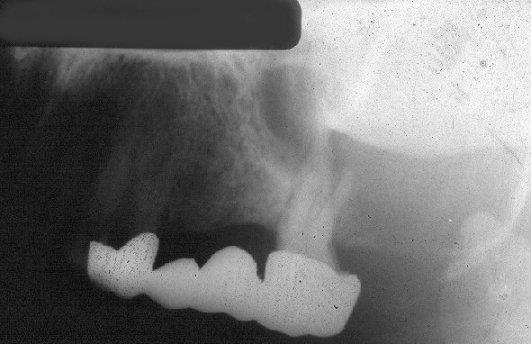

Searching for the closest document.
Reranking
Disease name 2: Calcifying epithelial odontogenic tumor (CEOT - Pindborg tumor)  
Disease 2 description: A rare benign odontogenic tumor. It usually affects middle-aged patients. Most common location is the premolar and molar region of the mandible. Radiographically, CEOT appears as a mixed radiolucent-radiopaque lesion, often with well-defined borders. Teeth displacement and root resorption are common findings.




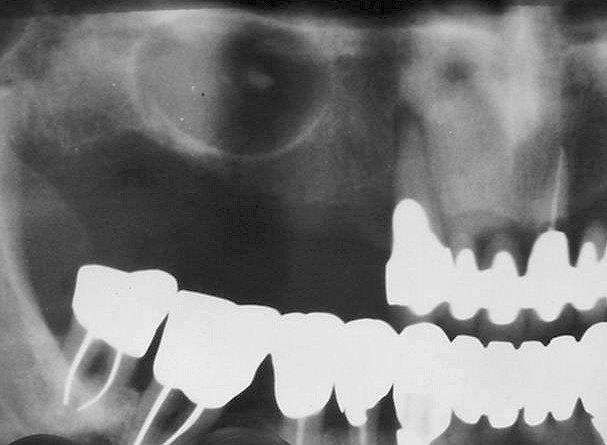

Searching for the closest document.
Reranking
Disease name 3: Odontogenic keratocyst  
Disease 3 description: Radiolucent lesion that may become large, often developing during the second and third decades of life. Most commonly located in the posterior mandible area but can be in maxilla. The lesion is usually unilocular with a tendency for cortical thinning or even perforation. Adjacent teeth are usually vital, and root resorption is rare, but can occur in some cases. The lesion can lead to tooth displacement or impaction.


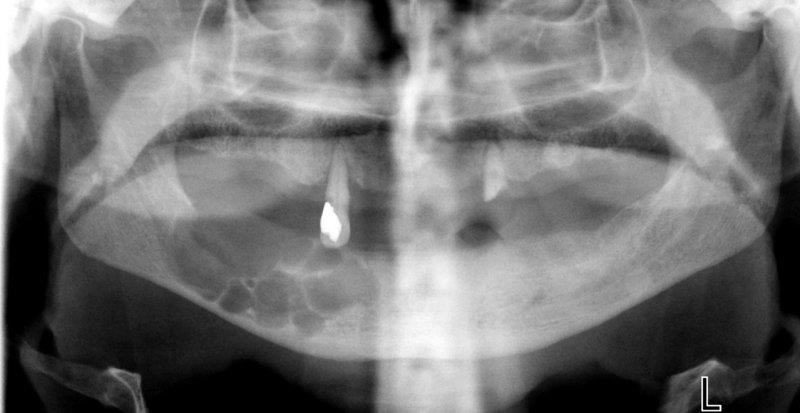

In [6]:
query = util.read_query(query_path).replace('\n', "")
predictions, image_paths, context = respond(query, text_collection_name, caption_collection_name, 10, 5, 0.8, 3)

# Prediction Evaluation

In [7]:
def evaluation(qa_pairs, 
               symptom_predictions_path, 
               image_predictions_path, 
               contexts_path, 
               text_collection_name, 
               caption_collection_name, 
               txt_similarity_topk, 
               image_similarity_topk, 
               cos_filtering_threshold, 
               cos_filtering_topk,
               eval_result_path,
               eval_record_path,
               sparse_sim_threshold
               ):
    
    truths = []
    queries = []
    for pair in qa_pairs:
        truths.append(pair['answer'])
        queries.append(pair['query'])

    if not os.path.exists(symptom_predictions_path) or not  os.path.exists(image_predictions_path) or not os.path.exists(contexts_path):
        print("Generating responses.")
        symptom_predictions = []
        image_predictions = []
        contexts = []
        
        for query in tqdm(queries):
            cleaned_query = query.replace('\n', "")
            cleaned_query = cleaned_query.strip()
            symptom_prediction, image_prediction, context = respond(
                                                                cleaned_query, 
                                                                text_collection_name, 
                                                                caption_collection_name, 
                                                                txt_similarity_topk, 
                                                                image_similarity_topk, 
                                                                cos_filtering_threshold, 
                                                                cos_filtering_topk,
                                                                verbose=0
                                                            )      
            symptom_predictions.append(symptom_prediction)
            image_predictions.append(image_prediction)
            contexts.append(context)

        util.save_as_json(symptom_predictions, symptom_predictions_path)
        util.save_as_json(image_predictions, image_predictions_path)
        util.save_as_json(contexts, contexts_path)

    else:
        symptom_predictions = util.load_json(symptom_predictions_path)
        image_predictions = util.load_json(image_predictions_path)

    disease_names_predictions = []
    for predictions in symptom_predictions:
        disease_names = []
        for entry in predictions:
            first_line = entry.split("\n")[0]
            disease_name = first_line.split(":", 1)[1].strip()
            disease_names.append(disease_name)
        disease_names_predictions.append(disease_names)

    evaluator = eval.Evaluator(truths, disease_names_predictions)
    evaluator.list_acc(sparse_sim_threshold)
    util.save_as_json(evaluator.score, eval_result_path)
    util.save_as_json(evaluator.record, eval_record_path)

In [8]:
qa_pairs = util.load_json('evaluation_dataset/qa_pairs.json')

evaluation(
    qa_pairs, 
    disease_predictions_path, 
    image_predictions_path, 
    contexts_path, 
    text_collection_name, 
    caption_collection_name, 
    txt_similarity_topk = 10, 
    image_similarity_topk = 3, 
    cos_filtering_threshold = 0.8, 
    cos_filtering_topk = 5,
    eval_result_path = eval_result_path,
    eval_record_path = eval_record_path,
    sparse_sim_threshold = 0.7
    )

Loaded content from evaluation_dataset/qa_pairs.json
Loaded content from robust_evaluation_results/disease_predictions.json
Loaded content from robust_evaluation_results/image_predictions.json
Saved content to robust_evaluation_results/score.json
Saved content to robust_evaluation_results/record.json


# Caption Evaluation

In [ ]:
true_pairs = util.load_json('evaluation_dataset/caption_evaluation.json')
true_labels = []
for pair in true_pairs:
    true_labels.append(pair['caption'])
print('True labels loaded!')

predictions = []
for i in range(2, 5):
    paired_captions = util.load_json(f'robust_all_contents/File{i}/Images_info.json')
    for paired_caption in paired_captions:
        predictions.append(paired_caption['caption'].split('\n')[0].split('Symptom:')[-1])
print('Predictions loaded!')

evaluator = eval.Evaluator(true_labels, predictions)
evaluator.single_acc(0.7)
util.save_as_json(evaluator.score, 'robust_evaluation_results/caption_evaluation_score.json')
util.save_as_json(evaluator.record, 'robust_evaluation_results/caption_evaluation_record.json')

Loaded content from evaluation_dataset/caption_evaluation.json
True labels loaded!
Loaded content from robust_all_contents/File2/Images_info.json
Loaded content from robust_all_contents/File3/Images_info.json
Loaded content from robust_all_contents/File4/Images_info.json
Predictions loaded!


97it [01:47,  1.11s/it]

Saved content to robust_evaluation_results/caption_evaluation_score.json
Saved content to robust_evaluation_results/caption_evaluation_record.json
